In [1]:
import xarray as xr
import gcsfs
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import time
from matplotlib.colors import LogNorm
from IPython.display import clear_output
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from intake import open_catalog

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import pandas as pd

/srv/conda/envs/notebook/lib/python3.8/site-packages/tensorflow/python/ops/random_ops.py:285: SyntaxWarning: "is" with a literal. Did you mean "=="?
  minval_is_zero = minval is 0  # pylint: disable=literal-comparison
/srv/conda/envs/notebook/lib/python3.8/site-packages/tensorflow/python/ops/random_ops.py:286: SyntaxWarning: "is" with a literal. Did you mean "=="?
  maxval_is_one = maxval is 1  # pylint: disable=literal-comparison
/srv/conda/envs/notebook/lib/python3.8/site-packages/tensorflow/python/ops/ragged/ragged_batch_gather_with_default_op.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (default_value.shape.ndims is not 0
/srv/conda/envs/notebook/lib/python3.8/site-packages/tensorflow/python/ops/ragged/ragged_batch_gather_with_default_op.py:85: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  and default_value.shape.ndims is not 1):


In [2]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 14, 'axes.labelsize' : 12,
      'legend.fontsize' : 13,'legend.handlelength': 3})

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'
# plt.rcParams['figure.figsize'] = (14.,5.)



blue = cm.get_cmap('Blues', 256)
green = cm.get_cmap('Greens', 256)
red = cm.get_cmap('Reds', 256)
grey = cm.get_cmap('Greys', 256)
bone = cm.get_cmap('bone_r', 256)
binary = cm.get_cmap('binary', 256)
hot = cm.get_cmap('hot_r', 256)
gray = cm.get_cmap('gray_r', 256)


newcolors5 = blue(np.linspace(0, 1, 256))**2*grey(np.linspace(0, 1, 256))**0.2
newcmp5 = ListedColormap(newcolors5[::-1], name='BlueGrey')

newcolors7 = blue(np.linspace(0, 1, 256))**1.5*green(np.linspace(0, 1, 256))**0.3*grey(np.linspace(0, 1, 256))**0.03
newcmp7 = ListedColormap(newcolors7[::-1], name='BluegreenGrey')

newcmp6 = ListedColormap(newcolors5, name='BlueGrey_r')
newcmp8 = ListedColormap(newcolors7, name='BlueGreenGrey_r')

def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

In [3]:
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml")
ds  = cat["CESM_POP_hires_control"].to_dask()
# ds

In [4]:
ds = ds.rename({'U1_1':'U', 'V1_1':'V', 'TAUX_2':'TAUX', 'TAUY_2':'TAUY', 'SSH_2':'SSH', 'ULONG':'XU', 'ULAT':'YU'})

def make_3d_coords(lon,lat):
    X = np.sin(np.radians(lat))
    Y = np.sin(np.radians(lon))*np.cos(np.radians(lat))
    Z = -np.cos(np.radians(lon))*np.cos(np.radians(lat))
    return (X,Y,Z)

X, Y, Z = make_3d_coords(ds.XU.data, ds.YU.data)

ds['X'] = ds.XU.dims, X
ds['Y'] = ds.XU.dims, Y
ds['Z'] = ds.XU.dims, Z

def normalize_gridspacing(DX,DY):
    dX = (DX - np.mean(DX))/np.std(DX)
    dY = (DY - np.mean(DY))/np.std(DY)
    
    return (dX, dY)

dX, dY = normalize_gridspacing(ds.DXT.data, ds.DYT.data)

ds['dx'] = ds.XU.dims, dX
ds['dy'] = ds.XU.dims, dY

ds

KeyboardInterrupt: 

In [ ]:
def reshape_stencil(data, ssize):
    assert data.ndim == 2
    ny, nx = data.shape
    data_rs = data.reshape((ny//ssize, ssize,  nx//ssize, ssize))
    # move stencil to end
    data_mv = np.moveaxis(data_rs, 1, 2)
    data_flat = data_mv.reshape((-1, 2, 2))
    return data_flat

def reshape_stencil_time(data, ssize):
    assert data.ndim == 3
    nt, ny, nx = data.shape
    data_rs = data.reshape((nt, ny//ssize, ssize,  nx//ssize, ssize))
    # move stencil to end
    data_mv = np.moveaxis(np.moveaxis(data_rs, 2, 3), 0,4)
    data_flat = data_mv.reshape((-1, 2, 2, 3))
    return data_flat

def extract_data_loc(ds, vname, stencil_size, indexer):
    data = ds[vname].values
    data_rs = reshape_stencil(data, stencil_size)
    data_idx = data_rs[(slice(None),) + indexer]
    return data_idx

# def extract_data_out(ds, vname, stencil_size, indexer):
#     data = ds[vname].values
#     data_rs = reshape_stencil(data[1], stencil_size)
#     data_idx = data_rs[(slice(None),) + indexer]
#     return data_idx

def extract_data(ds, vname, stencil_size, indexer):
    data = ds[vname].values
    data_rs = reshape_stencil_time(data, stencil_size)
    data_idx = data_rs[(slice(None),) + indexer]
    return data_idx

In [ ]:
def prepare_data_3dpointloc(ds, apply_mask=True, randomize=True, stencil_size = 2,
                            stencil_time_vars = ['SSH',], stencil_time_index = (slice(None), slice(None), slice(None)),
                            point_vars = ['TAUX', 'TAUY'], point_index = (1, 0, 0), 
                            loc_vars = ['X','dx','dy'], loc_index = (0, 0), 
                            target_vars = ['U', 'V'], target_index = (1, 0, 0) ):
    
    stencil_time_data = [extract_data(ds, vname, stencil_size, stencil_time_index)
                    for vname in stencil_time_vars]    
    loc_data = [extract_data_loc(ds, vname, stencil_size, loc_index)
                    for vname in loc_vars]
    point_data = [extract_data(ds, vname, stencil_size, point_index)
                   for vname in point_vars]
    target_data = [extract_data(ds, vname, stencil_size, target_index)
                   for vname in target_vars]

    if apply_mask:
        mask = np.isnan(stencil_time_data[0]).sum(axis=(1, 2, 3)) == 0
    else:
        mask = slice(None)
    if randomize:
        random_idx = np.random.permutation(mask.sum())
    else:
        random_idx = slice(None)

    features_stencil_time = np.stack([data[mask][random_idx] for data in stencil_time_data],
                                axis=-1)
    features_loc = np.stack([data[mask][random_idx] for data in loc_data],
                                axis=-1)
    
    features_point = np.stack([data[mask][random_idx] for data in point_data],
                               axis=-1)
    targets = np.stack([data[mask][random_idx] for data in target_data],
                        axis=-1)
    return [features_stencil_time, features_point, features_loc], targets


def prepare_data_3dloc(ds, apply_mask=True, randomize=True, stencil_size = 2,
                            stencil_time_vars = ['SSH',], stencil_time_index = (slice(None), slice(None), slice(None)),
                            loc_vars = ['X','dx','dy'], loc_index = (0, 0), 
                            target_vars = ['U', 'V'], target_index = (1, 0, 0) ):
    
    stencil_time_data = [extract_data(ds, vname, stencil_size, stencil_time_index)
                    for vname in stencil_time_vars]    
    loc_data = [extract_data_loc(ds, vname, stencil_size, loc_index)
                    for vname in loc_vars]
    target_data = [extract_data(ds, vname, stencil_size, target_index)
                   for vname in target_vars]

    if apply_mask:
        mask = np.isnan(stencil_time_data[0]).sum(axis=(1, 2, 3)) == 0
    else:
        mask = slice(None)
    if randomize:
        random_idx = np.random.permutation(mask.sum())
    else:
        random_idx = slice(None)

    features_stencil_time = np.stack([data[mask][random_idx] for data in stencil_time_data],
                                axis=-1)
    features_loc = np.stack([data[mask][random_idx] for data in loc_data],
                                axis=-1)
    targets = np.stack([data[mask][random_idx] for data in target_data],
                        axis=-1)
    return [features_stencil_time, features_loc], targets


In [ ]:
inputs = {}
targets = {}

In [ ]:
%%time

inputs['000'], targets['000'] = prepare_data_3dpointloc(ds.isel(time=slice(10, 13)),
                                                        stencil_time_vars = ['SSH',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X','dx','dy'])

inputs['001'], targets['001'] = prepare_data_3dpointloc(ds.isel(time=slice(10, 13)),
                                                        stencil_time_vars = ['SSH','SST',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X','dx','dy'])

inputs['002'], targets['002'] = prepare_data_3dpointloc(ds.isel(time=slice(10, 13)),
                                                        stencil_time_vars = ['SSH',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X'])

inputs['003'], targets['003'] = prepare_data_3dpointloc(ds.isel(time=slice(10, 13)),
                                                        stencil_time_vars = ['SSH', 'SST'], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X'])



In [ ]:
inputs['004'], targets['004'] = prepare_data_3dloc(ds.isel(time=slice(10, 13)),
                                                        stencil_time_vars = ['SSH',], 
                                                        loc_vars = ['X','dx','dy'])
inputs['005'], targets['005'] = prepare_data_3dloc(ds.isel(time=slice(10, 13)),
                                                        stencil_time_vars = ['SSH','SST'], 
                                                        loc_vars = ['X','dx','dy'])
inputs['006'], targets['006'] = prepare_data_3dloc(ds.isel(time=slice(10, 13)),
                                                        stencil_time_vars = ['SSH',], 
                                                        loc_vars = ['X',])
inputs['007'], targets['007'] = prepare_data_3dloc(ds.isel(time=slice(10, 13)),
                                                        stencil_time_vars = ['SSH','SST',], 
                                                        loc_vars = ['X',])
inputs['008'], targets['008'] = prepare_data_3dloc(ds.isel(time=slice(10, 13)),
                                                        stencil_time_vars = ['SSH','SST','TAUX','TAUY'], 
                                                        loc_vars = ['X',])
inputs['009'], targets['009'] = prepare_data_3dloc(ds.isel(time=slice(10, 13)),
                                                        stencil_time_vars = ['SSH','SST','TAUX','TAUY'], 
                                                        loc_vars = ['X','dx','dy'])


In [ ]:
inputs['010'], targets['010'] = prepare_data_3dpointloc(ds.isel(time=slice(10, 13)),
                                                        stencil_time_vars = ['SSH', 'SST', 'SSS',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X'])

inputs['011'], targets['011'] = prepare_data_3dpointloc(ds.isel(time=slice(10, 13)),
                                                        stencil_time_vars = ['SSH', 'SST', 'SSS'], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X', 'dx', 'dy'])

In [16]:
input_stencil_time = {}
input_points = {}
input_loc = {}
conv_layer = {}
reshape_layer = {}
concat_layer = {}
combined_relu = {}
hidden_layer_1 = {}
hidden_layer_2 = {}
hidden_layer_3 = {}
output_layer = {}
model = {}

nfilters = 80

for k in ['000','001','002','003','010','011']:
    input_stencil_time[k] = tf.keras.Input(shape=inputs[k][0].shape[1:])
    input_points[k] = tf.keras.Input(shape=inputs[k][1].shape[1:])
    input_loc[k] = tf.keras.Input(shape=inputs[k][2].shape[1:])

    conv_layer[k] = tf.keras.layers.Conv3D(nfilters, [2,2,3])(input_stencil_time[k])
    reshape_layer[k] = tf.keras.layers.Reshape((nfilters,))(conv_layer[k])


    concat_layer[k] = tf.keras.layers.concatenate([reshape_layer[k], input_points[k], input_loc[k]])
    combined_relu[k] = tf.keras.layers.LeakyReLU(alpha=0.3)(concat_layer[k])
    hidden_layer_1[k] = tf.keras.layers.Dense(40, activation='relu')(combined_relu[k])
    hidden_layer_2[k] = tf.keras.layers.Dense(20, activation='relu')(hidden_layer_1[k])
    hidden_layer_3[k] = tf.keras.layers.Dense(10, activation='relu')(hidden_layer_2[k])
    output_layer[k] = tf.keras.layers.Dense(2)(hidden_layer_3[k])


    model[k] = tf.keras.Model(inputs=[input_stencil_time[k], input_points[k], input_loc[k]],
                        outputs=output_layer[k])

    model[k].compile(loss='mae', optimizer='Adam', metrics=['mae', 'mse','accuracy'])
    model[k].summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 2, 3, 1)] 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 1, 1, 1, 80)  1040        input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 80)           0           conv3d[0][0]                     
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
______________________________________________________________________________________________

In [17]:
for k in ['004','005','006','007','008','009']:
    input_stencil_time[k] = tf.keras.Input(shape=inputs[k][0].shape[1:])
    input_loc[k] = tf.keras.Input(shape=inputs[k][1].shape[1:])

    conv_layer[k] = tf.keras.layers.Conv3D(nfilters, [2,2,3])(input_stencil_time[k])
    reshape_layer[k] = tf.keras.layers.Reshape((nfilters,))(conv_layer[k])


    concat_layer[k] = tf.keras.layers.concatenate([reshape_layer[k], input_loc[k]])
    combined_relu[k] = tf.keras.layers.LeakyReLU(alpha=0.3)(concat_layer[k])
    hidden_layer_1[k] = tf.keras.layers.Dense(40, activation='relu')(combined_relu[k])
    hidden_layer_2[k] = tf.keras.layers.Dense(20, activation='relu')(hidden_layer_1[k])
    hidden_layer_3[k] = tf.keras.layers.Dense(10, activation='relu')(hidden_layer_2[k])
    output_layer[k] = tf.keras.layers.Dense(2)(hidden_layer_3[k])


    model[k] = tf.keras.Model(inputs=[input_stencil_time[k], input_loc[k]],
                        outputs=output_layer[k])

    model[k].compile(loss='mae', optimizer='Adam', metrics=['mae', 'mse','accuracy'])
    model[k].summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 2, 2, 3, 1)] 0                                            
__________________________________________________________________________________________________
conv3d_6 (Conv3D)               (None, 1, 1, 1, 80)  1040        input_19[0][0]                   
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 80)           0           conv3d_6[0][0]                   
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 3)]          0                                            
____________________________________________________________________________________________

In [18]:
labels = {}

labels['000'] = 'SSH_3pt2ps_pointXdxdyTAUXTAUY_3l_402010_nf80'
labels['001'] = 'SSHSST_3pt2ps_pointXdxdyTAUXTAUY_3l_402010_nf80'
labels['002'] = 'SSH_3pt2ps_pointXTAUXTAUY_3l_402010_nf80'
labels['003'] = 'SSHSST_3pt2ps_pointXTAUXTAUY_3l_402010_nf80'



labels['004'] = 'SSH_3pt2ps_pointXdxdy_3l_402010_nf80'
labels['005'] = 'SSHSST_3pt2ps_pointXdxdy_3l_402010_nf80'
labels['006'] = 'SSH_3pt2ps_pointX_3l_402010_nf80'
labels['007'] = 'SSHSST_3pt2ps_pointX_3l_402010_nf80'
labels['008'] = 'SSHSSTTAUXTAUY_3pt2ps_pointX_3l_402010_nf80'
labels['009'] = 'SSHSSTTAUXTAUY_3pt2ps_pointXdxdy_3l_402010_nf80'


labels['010'] = 'SSHSSTSSS_3pt2ps_pointXTAUXTAUY_3l_402010_nf80'
labels['011'] = 'SSHSSTSSS_3pt2ps_pointXdxdyTAUXTAUY_3l_402010_nf80'



In [21]:
labels

{'000': 'SSH_3pt2ps_pointXdxdyTAUXTAUY_3l_402010_nf80',
 '001': 'SSHSST_3pt2ps_pointXdxdyTAUXTAUY_3l_402010_nf80',
 '002': 'SSH_3pt2ps_pointXTAUXTAUY_3l_402010_nf80',
 '003': 'SSHSST_3pt2ps_pointXTAUXTAUY_3l_402010_nf80',
 '004': 'SSH_3pt2ps_pointXdxdy_3l_402010_nf80',
 '005': 'SSHSST_3pt2ps_pointXdxdy_3l_402010_nf80',
 '006': 'SSH_3pt2ps_pointX_3l_402010_nf80',
 '007': 'SSHSST_3pt2ps_pointX_3l_402010_nf80',
 '008': 'SSHSSTTAUXTAUY_3pt2ps_pointX_3l_402010_nf80',
 '009': 'SSHSSTTAUXTAUY_3pt2ps_pointXdxdy_3l_402010_nf80',
 '010': 'SSHSSTSSS_3pt2ps_pointXTAUXTAUY_3l_402010_nf80',
 '011': 'SSHSSTSSS_3pt2ps_pointXdxdyTAUXTAUY_3l_402010_nf80'}

In [19]:
# this will help save training history more frequently
# https://keras.io/callbacks/#create-a-callback

class LossHistory(keras.callbacks.Callback):
    def __init__(self, frequency=100):
        self.frequency = frequency
        self.batch_counter = 0
        self.losses = []
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.mse = []
        self.accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []
        
    def on_batch_end(self, batch, logs={}):
        if batch % self.frequency == 0:
            self.batch_counter += self.frequency
            self.logs.append(logs)
            self.x.append(self.i)
            self.losses.append(logs.get('loss'))
            self.mse.append(logs.get('mse'))
            self.accuracy.append(logs.get('accuracy'))
        
            self.i += 1
        
            clear_output(wait=True)
            plt.figure(figsize=(18,5))
            plt.subplot(131)
            plt.plot(self.x, self.losses,color=color1,label="loss")
            plt.plot(self.x[-1], self.losses[-1],marker = 'o', markersize=10, color=color1)
            plt.legend()
            plt.xlabel(r'batch');
            plt.ylabel('Mean Absolute Error');
            plt.ylim([2,12])
            plt.subplot(132)
            plt.plot(self.x, self.mse, color=color2)
            plt.plot(self.x[-1], self.mse[-1],marker = 'o', markersize=10, color=color2)
            plt.xlabel('batch');
            plt.ylabel(r'Mean Squared Error [$cm^2/s^2$]');
            plt.ylim([10,330])

            plt.subplot(133)
            plt.plot(self.x, self.accuracy, color=color3)
            plt.plot(self.x[-1], self.accuracy[-1],marker = 'o', markersize=10, color=color3)
            plt.xlabel('batch');
            plt.ylabel('Model Accuracy');
            plt.ylim([0.1,0.95])

            plt.show();

In [20]:
history = {}

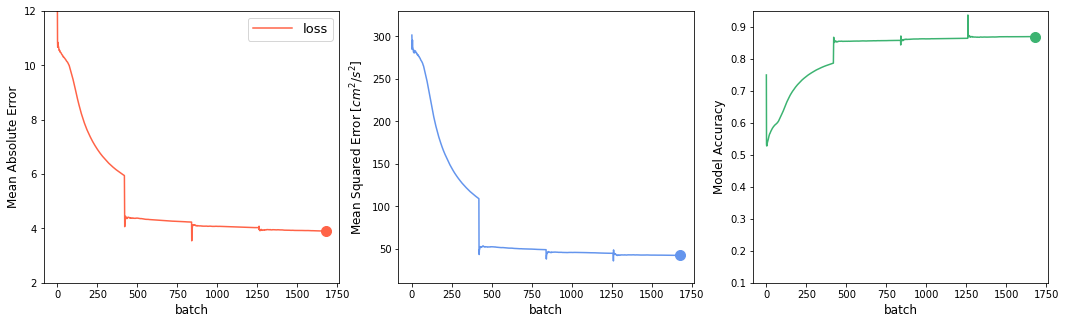

41967/41967 [==============================] - 305s 7ms/step - loss: 3.9047 - mae: 3.9047 - mse: 42.2255 - accuracy: 0.8699
INFO:tensorflow:Assets written to: models/SSH_3pt2ps_pointXdxdyTAUXTAUY_3l_402010_nf80/assets


In [29]:
mnum = '000'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


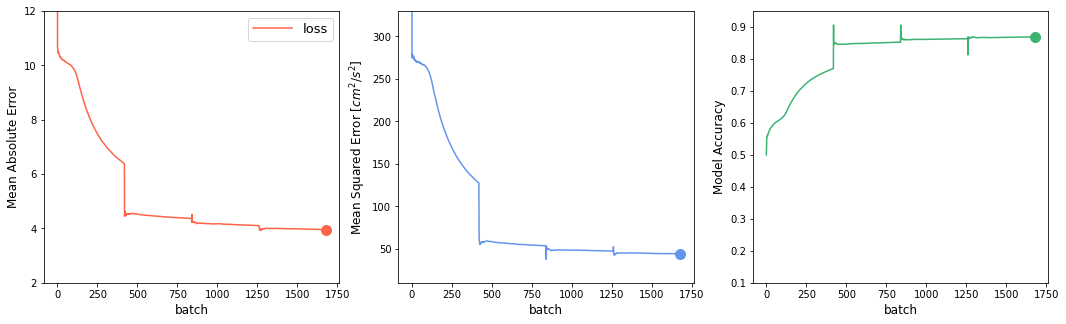

41967/41967 [==============================] - 567s 14ms/step - loss: 3.9561 - mae: 3.9561 - mse: 44.1748 - accuracy: 0.8690
INFO:tensorflow:Assets written to: models/SSHSST_3pt2ps_pointXdxdyTAUXTAUY_3l_402010_nf80/assets


In [31]:
mnum = '001'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


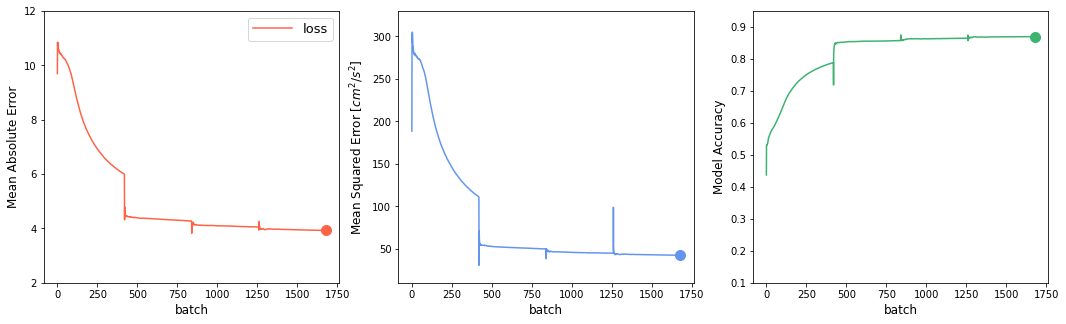

41967/41967 [==============================] - 303s 7ms/step - loss: 3.9257 - mae: 3.9257 - mse: 42.4111 - accuracy: 0.8700
INFO:tensorflow:Assets written to: models/SSH_3pt2ps_pointXTAUXTAUY_3l_402010_nf80/assets


In [32]:
mnum = '002'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


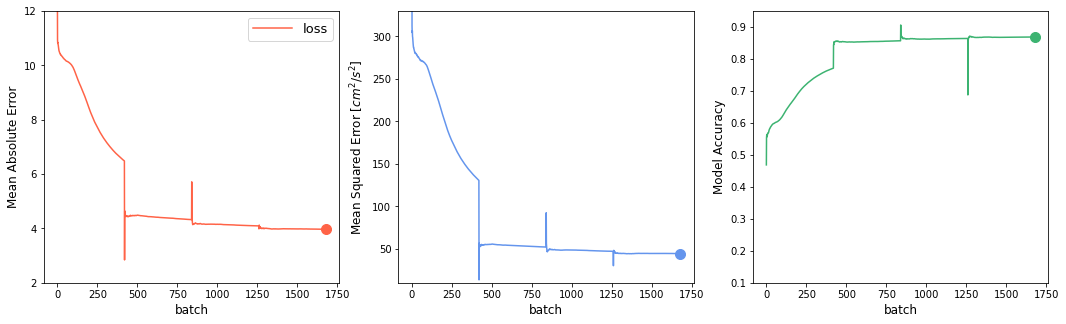

41967/41967 [==============================] - 307s 7ms/step - loss: 3.9678 - mae: 3.9678 - mse: 44.3623 - accuracy: 0.8687
INFO:tensorflow:Assets written to: models/SSHSST_3pt2ps_pointXTAUXTAUY_3l_402010_nf80/assets


In [33]:
mnum = '003'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


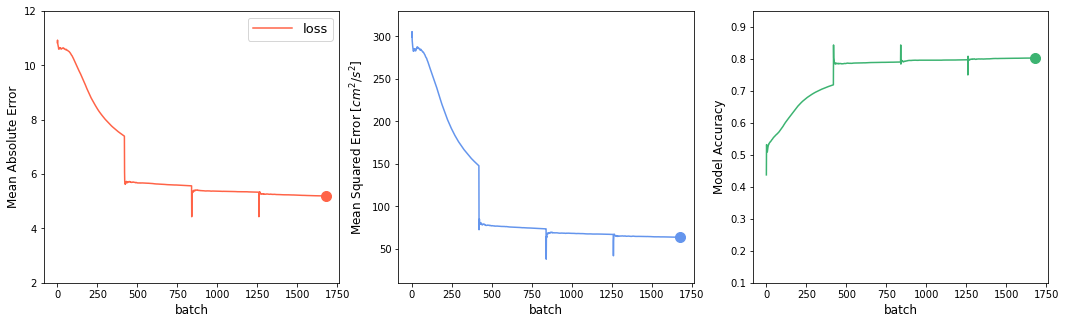

41967/41967 [==============================] - 300s 7ms/step - loss: 5.1945 - mae: 5.1945 - mse: 63.5883 - accuracy: 0.8029
INFO:tensorflow:Assets written to: models/SSH_3pt2ps_pointXdxdy_3l_402010_nf80/assets


In [34]:
mnum = '004'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


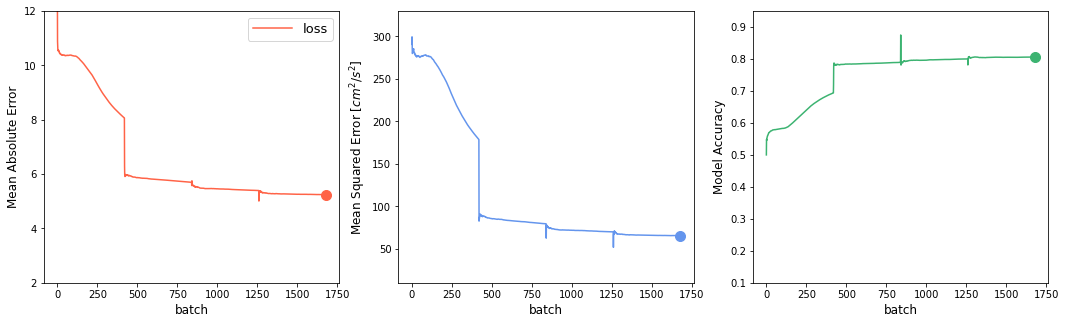

41967/41967 [==============================] - 303s 7ms/step - loss: 5.2410 - mae: 5.2410 - mse: 65.4017 - accuracy: 0.8061
INFO:tensorflow:Assets written to: models/SSHSST_3pt2ps_pointXdxdy_3l_402010_nf80/assets


In [35]:
mnum = '005'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


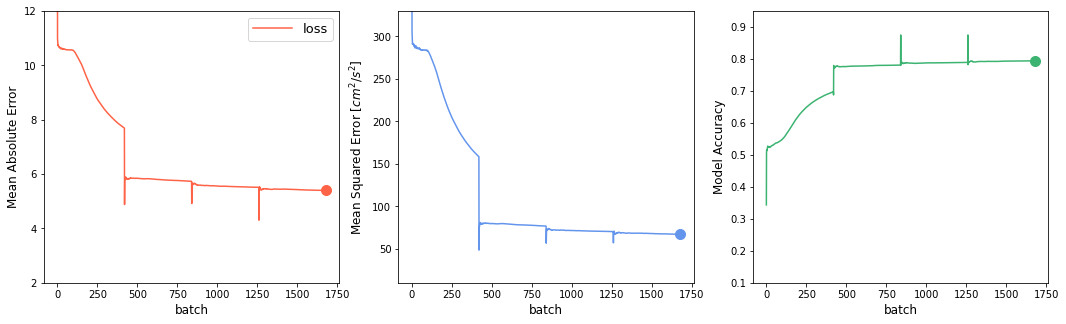

41967/41967 [==============================] - 312s 7ms/step - loss: 5.3973 - mae: 5.3973 - mse: 67.1223 - accuracy: 0.7941
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/SSH_3pt2ps_pointX_3l_402010_nf80/assets


In [22]:
mnum = '006'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


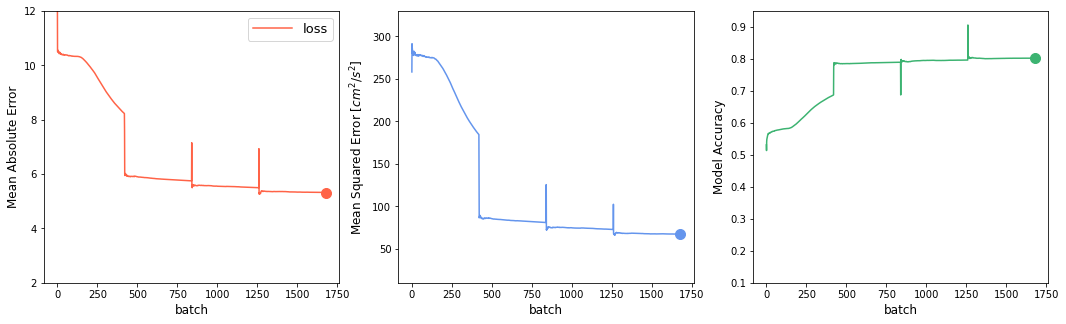

41967/41967 [==============================] - 305s 7ms/step - loss: 5.3222 - mae: 5.3222 - mse: 67.2876 - accuracy: 0.8028
INFO:tensorflow:Assets written to: models/SSHSST_3pt2ps_pointX_3l_402010_nf80/assets


In [37]:
mnum = '007'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


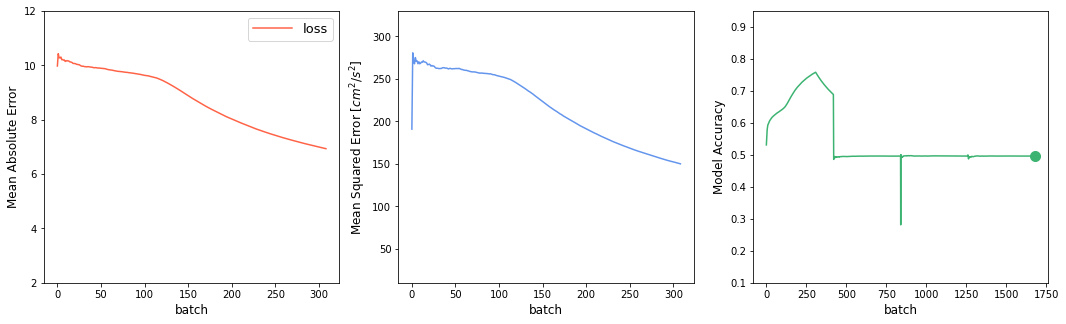

41967/41967 [==============================] - 271s 6ms/step - loss: nan - mae: nan - mse: nan - accuracy: 0.4963
INFO:tensorflow:Assets written to: models/SSHSSTTAUXTAUY_3pt2ps_pointX_3l_402010_nf80/assets


In [38]:
mnum = '008'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


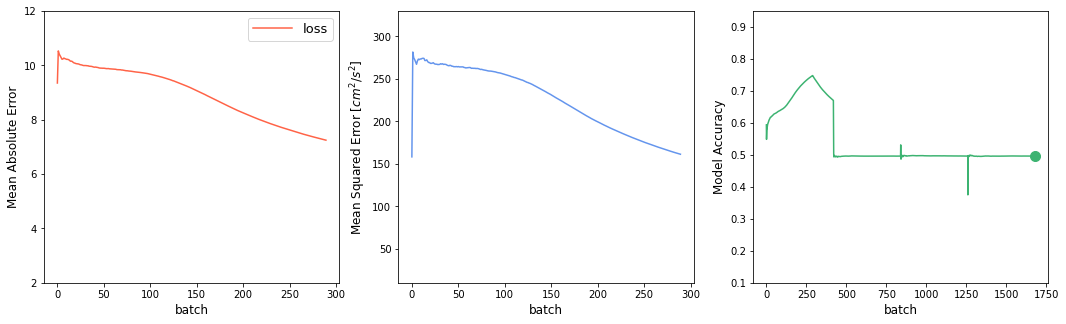

41967/41967 [==============================] - 272s 6ms/step - loss: nan - mae: nan - mse: nan - accuracy: 0.4963
INFO:tensorflow:Assets written to: models/SSHSSTTAUXTAUY_3pt2ps_pointXdxdy_3l_402010_nf80/assets


In [39]:
mnum = '009'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


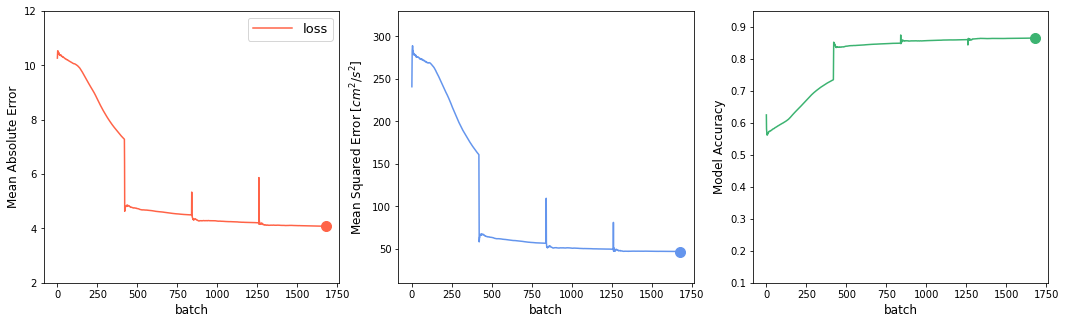

41967/41967 [==============================] - 271s 6ms/step - loss: 4.0794 - mae: 4.0794 - mse: 46.7768 - accuracy: 0.8655
INFO:tensorflow:Assets written to: models/SSHSSTSSS_3pt2ps_pointXTAUXTAUY_3l_402010_nf80/assets


In [40]:
mnum = '010'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


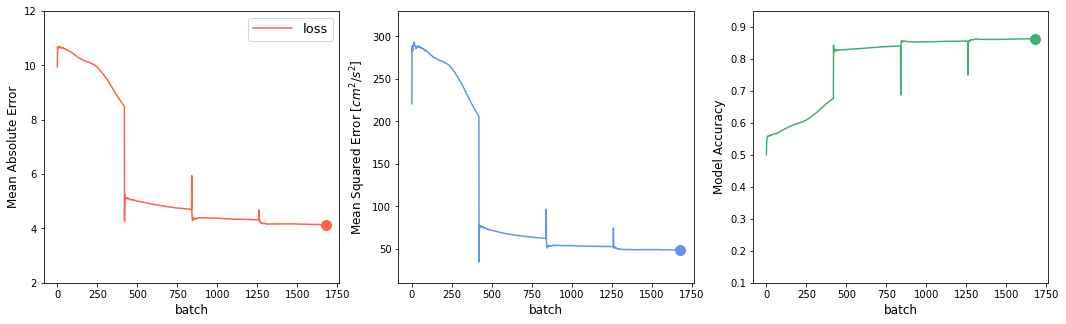

41967/41967 [==============================] - 268s 6ms/step - loss: 4.1358 - mae: 4.1358 - mse: 48.7088 - accuracy: 0.8636
INFO:tensorflow:Assets written to: models/SSHSSTSSS_3pt2ps_pointXdxdyTAUXTAUY_3l_402010_nf80/assets


In [41]:
mnum = '011'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


In [42]:

features_test = {}
targets_test = {}

features_pred = {}
targets_true = {}


NameError: name 'model' is not defined

In [ ]:
%%time

features_pred['000'], targets_true['000'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=False, randomize=False,)
features_pred['001'], targets_true['001'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH','SST',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=False, randomize=False,)
features_pred['002'], targets_true['002'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X'], apply_mask=False, randomize=False,)
features_pred['003'], targets_true['003'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH', 'SST'], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X'], apply_mask=False, randomize=False,)
features_pred['004'], targets_true['004'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH',], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=False, randomize=False,)
features_pred['005'], targets_true['005'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH','SST'], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=False, randomize=False,)
features_pred['006'], targets_true['006'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH',], 
                                                        loc_vars = ['X',], apply_mask=False, randomize=False,)
features_pred['007'], targets_true['007'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH','SST',], 
                                                        loc_vars = ['X',], apply_mask=False, randomize=False,)
features_pred['008'], targets_true['008'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH','SST','TAUX','TAUY'], 
                                                        loc_vars = ['X',], apply_mask=False, randomize=False,)
features_pred['009'], targets_true['009'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH','SST','TAUX','TAUY'], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=False, randomize=False,)
features_pred['010'], targets_true['010'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH', 'SST', 'SSS',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X'], apply_mask=False, randomize=False,)
features_pred['011'], targets_true['011'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH', 'SST', 'SSS'], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X', 'dx', 'dy'], apply_mask=False, randomize=False,)



In [ ]:

features_test['000'], targets_test['000'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=True, randomize=False,)
features_test['001'], targets_test['001'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH','SST',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=True, randomize=False,)
features_test['002'], targets_test['002'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X'], apply_mask=True, randomize=False,)
features_test['003'], targets_test['003'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH', 'SST'], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X'], apply_mask=True, randomize=False,)
features_test['004'], targets_test['004'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH',], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=True, randomize=False,)
features_test['005'], targets_test['005'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH','SST'], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=True, randomize=False,)
features_test['006'], targets_test['006'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH',], 
                                                        loc_vars = ['X',], apply_mask=True, randomize=False,)
features_test['007'], targets_test['007'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH','SST',], 
                                                        loc_vars = ['X',], apply_mask=False, randomize=False,)
features_test['008'], targets_test['008'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH','SST','TAUX','TAUY'], 
                                                        loc_vars = ['X',], apply_mask=True, randomize=False,)
features_test['009'], targets_test['009'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH','SST','TAUX','TAUY'], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=True, randomize=False,)
features_test['010'], targets_test['010'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH', 'SST', 'SSS',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X'], apply_mask=True, randomize=False,)
features_test['011'], targets_test['011'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH', 'SST', 'SSS'], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X', 'dx', 'dy'], apply_mask=True, randomize=False,)



In [ ]:
for mnum in model.keys():
    model[mnum].evaluate(features_test[mnum], targets_test[mnum])


In [ ]:
## Fill these in
# mae = np.array([7.7946, 5.1257, 5.1260, 3.1067, 3.2977, 3.0840, 3.2387, 3.3040, 3.7069, 3.6339, 3.2265, 4.0232])
# mse = np.array([233.0203, 63.3984, 65.9020, 39.5688, 36.4640, 34.4702, 39.0651, 37.6900, 41.3248, 40.4397, 36.7599, 46.0133 ])
# acc = np.array([0.6970, 0.7765, 0.7963, 0.9063, 0.8699, 0.8924, 0.9052, 0.8779, 0.8557, 0.8388, 0.8937, 0.9123 ])
loss_ev = {}
mse_ev = {}
acc_ev = {}
for i,r in enumerate(model.keys()):
    loss_ev[r] = mae[i]
    mse_ev[r] = mse[i]
    acc_ev[r] = acc[i]


In [ ]:
for mnum in model.keys():
    start = timer()
    targets_pred[mnum] = model[mnum].predict(features_pred[mnum])
    end = timer()
    print(mnum, end - start)

In [ ]:
colors = {'00': 'rosybrown', 
          '01' : 'royalblue', 
          '02' : 'mediumblue', 
          '03' : 'midnightblue', 
          '04' : 'slateblue', 
          '05' : 'mediumorchid', 
          '06': 'violet', 
          '07' : 'mediumvioletred', 
          '08' : 'crimson', 
          '09' : 'firebrick', 
          '10' : 'coral', 
          '11' : 'chocolate'
         }


In [ ]:
plt.figure(figsize=(15,15), tight_layout=True, dpi=100)
for r in ['001','003','005','006','007',]:
    plt.subplot(331)
    plt.plot(history[r].losses, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(loss_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel(r'batch');
    plt.ylabel('Mean Absolute Error');
    plt.xlim([0,1750])
    plt.ylim([2,12])
    plt.grid()
#     plt.legend()
    
    plt.subplot(332)
    plt.plot(history[r].mse, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(mse_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel('batch');
    plt.ylabel(r'Mean Squared Error [$cm^2/s^2$]');
    plt.xlim([0,1750])
    plt.ylim([10,330])
    plt.grid(axis='both')
#     plt.legend()

    plt.subplot(333)
    plt.plot(history[r].accuracy, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(acc_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel('batch');
    plt.ylabel('Model Accuracy');
    plt.xlim([0,1750])
    plt.ylim([0.1,0.95])
    plt.grid()
    plt.legend(fontsize=8)

for r in ['000','002','004']:
    plt.subplot(334)
    plt.plot(history[r].losses, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(loss_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel(r'batch');
    plt.ylabel('Mean Absolute Error');
    plt.xlim([0,1750])
    plt.ylim([2,12])
    plt.grid()
#     plt.legend()
    
    plt.subplot(335)
    plt.plot(history[r].mse, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(mse_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel('batch');
    plt.ylabel(r'Mean Squared Error [$cm^2/s^2$]');
    plt.xlim([0,1750])
    plt.ylim([10,330])
    plt.grid(axis='both')
#     plt.legend()

    plt.subplot(336)
    plt.plot(history[r].accuracy, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(acc_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel('batch');
    plt.ylabel('Model Accuracy');
    plt.xlim([0,1750])
    plt.ylim([0.1,0.95])
    plt.grid()
    plt.legend(fontsize=8)
    
for r in ['010','011']:
    plt.subplot(337)
    plt.plot(history[r].losses, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(loss_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel(r'batch');
    plt.ylabel('Mean Absolute Error');
    plt.xlim([0,1750])
    plt.ylim([2,12])
    plt.grid()
#     plt.legend()
    
    plt.subplot(338)
    plt.plot(history[r].mse, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(mse_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel('batch');
    plt.ylabel(r'Mean Squared Error [$cm^2/s^2$]');
    plt.xlim([0,1750])
    plt.ylim([10,330])
    plt.grid(axis='both')
#     plt.legend()

    plt.subplot(339)
    plt.plot(history[r].accuracy, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(acc_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel('batch');
    plt.ylabel('Model Accuracy');
    plt.xlim([0,1750])
    plt.ylim([0.1,0.95])
    plt.legend(fontsize=8)
    plt.grid()


In [ ]:
def unstack(data_flat, original_shape, stencil_size, target_index=(0, 0)):
    sub_shape = tuple(np.asarray(original_shape) // stencil_size)
    return data_flat.reshape(sub_shape)

In [ ]:
%%time

rms_err_zonmean = {}
rms_vel_zonmean = {}
rel_rmse_zonmean = {}
U_true = {}
V_true = {}
U_pred = {}
V_pred = {}
U_err = {}
V_err = {}
u_true_flat = {}
v_true_flat = {}
u_pred_flat = {}
v_pred_flat = {}

for mnum in model.keys():
    rms_err_zonmean[mnum] = np.nanmean(np.sqrt(unstack(np.sum((targets_true[mnum] - targets_pred[mnum])**2, axis=1), 
                                                       ds.U.shape[1:], 2)),axis=1)
    rms_vel_zonmean[mnum] = np.nanmean(np.sqrt(unstack(np.sum((targets_true[mnum])**2, axis=1), 
                                                       ds.U.shape[1:], 2)),axis=1)
    rel_rmse_zonmean[mnum] = np.nanmean(np.sqrt(unstack(np.sum((targets_true[mnum] - targets_pred[mnum])**2, axis=1), ds.U.shape[1:], 2) / 
                                                unstack(np.sum((targets_true[mnum])**2, axis=1),ds.U.shape[1:], 2)
                                               ),
                                        axis=1)

    U_true[mnum] = unstack(targets_true[mnum][:, 0], ds.U.shape[1:], 2)
    V_true[mnum] = unstack(targets_true[mnum][:, 1], ds.U.shape[1:], 2)
    U_pred[mnum] = unstack(targets_pred[mnum][:, 0], ds.U.shape[1:], 2)
    V_pred[mnum] = unstack(targets_pred[mnum][:, 1], ds.U.shape[1:], 2)
    U_err[mnum] = U_true[mnum] - U_pred[mnum]
    V_err[mnum] = V_true[mnum] - V_pred[mnum]
    u_true_flat[mnum], u_pred_flat[mnum], v_true_flat[mnum], v_pred_flat[mnum] = [np.ma.masked_invalid(data).ravel() 
                                                                                  for data in (U_true[mnum], U_pred[mnum], V_true[mnum], V_pred[mnum])]